In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

def corr_between(a,b):
    a_len = a.shape[1]
    return np.corrcoef(a, b, rowvar=False)[:a_len,a_len:]

In [2]:
names_m = ['Period', 'Duration', 'Time of Transit Epoch', 'r/R', 'a/R',
       'Inclination', 'Impact Parameter', 'Fitted Stellar Density',
       'Limb Darkening Coeff1', 'Limb Darkening Coeff2']

#### Metadatos Extraídos de la curva de luz
Generados a través de best-fit parámetros de un ajuste Mandel-Agol
* 1) Period 
> asociado al tiempo entre repeticiones o extensión de la órbita
* 3) Time of Transit Epoch (T0)
> tiempo en que inicia el tránsito
* 4) r/R
> Radio del planeta indica la profunidad del tránsito
* 5) a/R
> Radio de órbita indica qué tan alejado está el planeta de estrella, se refleja en la duración del tránsito.
* 6) Inclination 
> ángulo de inclinación indica el ángulo entre el plano perpendicular a la estrella y de la estrella al planeta (si =90, órbita es perpendicular a la visión)
* 9) Limb Darkening Coeff1 (con cross-matching)
* 10) Limb Darkening Coeff2 (con cross-matching)
> Asociados al decaimiento de luz producido en los bordes de la estrella (no son un cuerpo negro)
* Eccentricity y Periastron no fueron calculados (todos null) 

Extras (*Ningún cálculo es lineal*):
* 2) Duration 
> duración de eclipse. **Calculado** en base al periodo, radio órbita y radio planeta
* 7) Impact Parameter (circular)
> distancia del planeta al eje de visión de estrella. **Calculado** en base a radio órbita e inclination
* 8) Fitted Stellar Density
> **Calculado** en base al periodo, radio de planeta y duración de eclipse (see Seager and Mallen-Ornelas 2003).


En base a estrella:
* Teq 
> temperatura de equilibrio del planeta, cálculos necesitan info d la estrella.
* Teff
* Stellar Radius
* Stellar Mass
> temperatura efectiva, radio y masa de la estrella madre. (generados con *cross-matching*)

Docu: https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html  
refs:  
https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/  
https://www.hs.uni-hamburg.de/DE/Ins/Per/Czesla/PyA/PyA/pyaslDoc/aslDoc/transitDuration.html  
https://cds.cern.ch/record/560538/files/0206228.pdf

### All Metadata

In [82]:
names_m = ["Period", "Duration", "Time of Transit Epoch", "r/R", "a/R","Inclination", "Impact Parameter", 
            "Fitted Stellar Density", "Limb Darkening Coeff1", "Limb Darkening Coeff2"]

x_meta = np.load("../obj4/LC_features/MetadataLC.npy") #solo las 10 asociadas a la curva

#re-ordenar
aux = pd.DataFrame(x_meta, columns=names_m)
names_m = ["Period", "Time of Transit Epoch", "r/R", "a/R","Inclination", "Limb Darkening Coeff1", "Limb Darkening Coeff2",
           "Duration", "Impact Parameter", "Fitted Stellar Density"]
x_meta = aux[names_m].values

print("data shape=",x_meta.shape)

data shape= (8054, 10)


In [83]:
star_names_m = ["Teq","Teff","Stellar Radius", "Stellar Mass"] #añado la que usa estrella --metallicity?

df_meta = pd.read_csv("../../KOI_Data/koi_metadata.csv")
df_meta_obj = df_meta[star_names_m]

#fill nans
mask_cand = df_meta["NExScI Disposition"] == "CANDIDATE"
cand_nans = np.any(pd.isna(df_meta_obj[mask_cand]))
df_meta_obj[mask_cand] = df_meta_obj[mask_cand].fillna(df_meta_obj[mask_cand].median(),inplace=False)
mask_fp = df_meta["NExScI Disposition"] == "FALSE POSITIVE"
cand_fp = np.any(pd.isna(df_meta_obj[mask_fp]))
df_meta_obj[mask_fp] = df_meta_obj[mask_fp].fillna(df_meta_obj[mask_fp].median(),inplace=False)

x_meta_star = df_meta_obj.values
print("data shape=",x_meta_star.shape)

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(indexer, value)
/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

data shape= (8054, 4)


In [84]:
all_names_m = names_m + star_names_m

x_all_meta = np.concatenate([x_meta,x_meta_star], axis=1)
print("data shape=",x_all_meta.shape)

data shape= (8054, 14)


In [107]:
def summary_features(a):    
    res = pd.DataFrame()
    res["Features"] = ["feat-"+str(value) for value in np.arange(0, len(a))]
    #res["Corr - Mean (7)"] = a[:,:7].mean(axis=-1)
    res["Mean abs (7)"] = np.abs(a[:,:7]).mean(axis=-1)
    #res["Mean (10)"] = a[:,:10].mean(axis=-1)
    res["Mean abs (10)"] = np.abs(a[:,:10]).mean(axis=-1)
    #res["Mean (all)"] = a.mean(axis=1)
    res["Mean abs (all)"] = np.abs(a).mean(axis=1)
    
    res = res.sort_values(by=["Mean abs (7)"], ascending=False) #retornar ordenado por correlacion a los 7 "raw"
    res.reset_index(drop=True, inplace=True)
    
    res.loc[len(a)] = ["Global", 
                         res["Mean abs (7)"].mean(),
                         res["Mean abs (10)"].mean(),
                         res["Mean abs (all)"].mean()]
    return res

In [105]:
latent_dim = 16 #o 32
T = 300 #unico ejecuutado

### Autoencoder

In [92]:
z_AE = np.load("./LC_features/AE_%dT_%dD.npy"%(T,latent_dim))
print("data shape=",z_AE.shape)

data shape= (8054, 16)


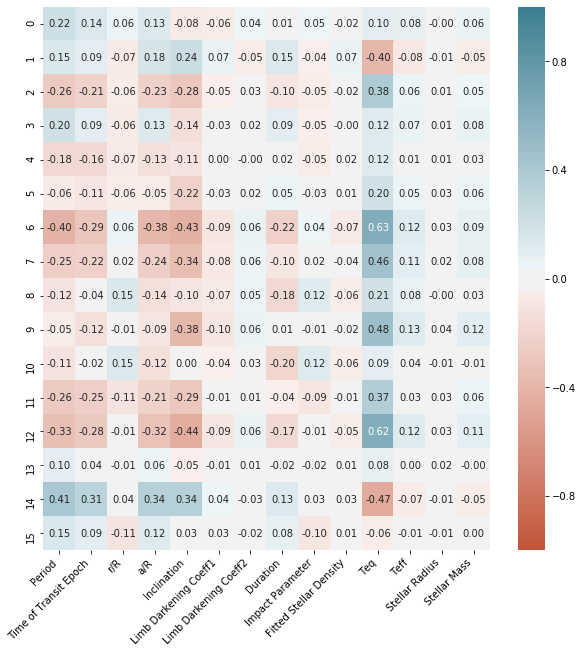

In [96]:
corr = corr_between(z_AE, x_all_meta)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True, fmt=".2f",
)
ax.set_xticklabels(
    all_names_m,
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [108]:
summary_features(corr)

,Features,Mean abs (7),Mean abs (10),Mean abs (all)
0,feat-6,0.244798,0.205069,0.208710
1,feat-12,0.220290,0.177540,0.189269
2,feat-14,0.216627,0.171300,0.165356
3,feat-7,0.171389,0.135202,0.144972
4,feat-11,0.163874,0.129082,0.126277
5,feat-2,0.160093,0.128876,0.127776
6,feat-1,0.120755,0.110345,0.117525
7,feat-9,0.115526,0.084433,0.114337
8,feat-0,0.106047,0.082352,0.076293
9,feat-3,0.096580,0.081894,0.077971


### Variational Autoencoder

In [112]:
z_VAE = np.load("./LC_features/VAE_%dT_%dD.npy"%(T,latent_dim))
print("data shape=",z_VAE.shape)

data shape= (8054, 16)


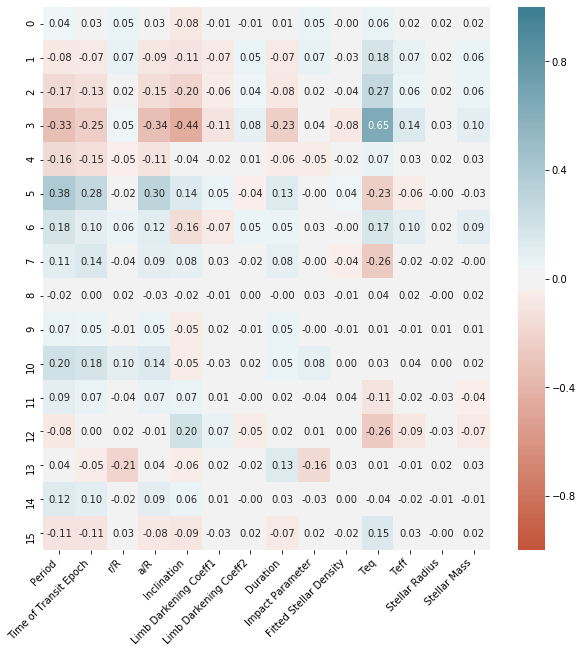

In [113]:
corr = corr_between(z_VAE, x_all_meta)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True, fmt=".2f",
)
ax.set_xticklabels(
    all_names_m,
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [114]:
summary_features(corr)

,Features,Mean abs (7),Mean abs (10),Mean abs (all)
0,feat-3,0.227821,0.193604,0.203395
1,feat-5,0.172993,0.138215,0.121673
2,feat-2,0.112258,0.092711,0.095111
3,feat-10,0.103816,0.086560,0.068791
4,feat-6,0.103768,0.081170,0.084549
5,feat-1,0.079112,0.073505,0.075841
6,feat-4,0.075658,0.066462,0.058104
7,feat-7,0.072643,0.063906,0.067661
8,feat-15,0.069277,0.059845,0.056501
9,feat-13,0.062037,0.075663,0.058668


### VAE + escala

In [115]:
z_VAEs = np.load("./LC_features/VAE_S_%dT_%dD.npy"%(T,latent_dim))
print("data shape=",z_VAEs.shape)

data shape= (8054, 16)


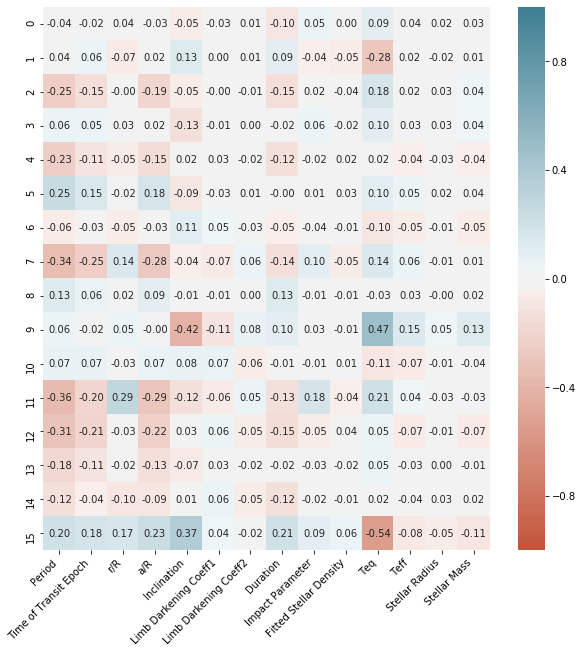

In [116]:
corr = corr_between(z_VAEs, x_all_meta)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True, fmt=".2f",
)
ax.set_xticklabels(
    all_names_m,
    rotation=45,
    horizontalalignment='right'
)
plt.show()

ahora si "pilla" mejor el r/R .. debido a que tiene la escala como input..

In [117]:
summary_features(corr)

,Features,Mean abs (7),Mean abs (10),Mean abs (all)
0,feat-11,0.196809,0.172913,0.145688
1,feat-15,0.173331,0.157368,0.167762
2,feat-7,0.169500,0.148093,0.121908
3,feat-12,0.129860,0.114416,0.096445
4,feat-9,0.106202,0.088075,0.119449
5,feat-5,0.104184,0.077193,0.070623
6,feat-2,0.092936,0.085621,0.080543
7,feat-4,0.088090,0.077582,0.065380
8,feat-13,0.080387,0.063188,0.051251
9,feat-14,0.068911,0.063802,0.052783


Modelo VAE pareciera ser más independiente **linealmente** a los metadatos, quizás encuentre cosas más allá?

### Generar curva en VAE, variando Z

In [ ]:
## load data


In [ ]:
from autoencoder_utils import get_GRU
from autoencoder_utils import define_samp_model
from autoencoder_utils import Mul_L,  Div_L
latent_dim = 16
EPOCHS = 300


#escalamodel


VRAES_t.summary()
SVG(model_to_dot(VRAES_t).create(prog='dot', format='svg'))

In [ ]:
## load model..
VRAES_t.get_layer("encoder").load_weights("./models/VAE-S_%dT_%dD_%de_E.h5"%(T,latent_dim,EPOCHS))
VRAES_t.get_layer("generator").load_weights("./models/VAE-S_%dT_%dD_%de_D.h5"%(T,latent_dim,EPOCHS))

In [ ]:
### necesito un tiempo de referencia..
time_i = X_test_t[0][None,:,:]

In [118]:
n = 10 #data to generate

#op1:
z_sampleds = np.zeros((n,latent_dim))

#op2:
#z_sampleds = np.mean(z_VAEs, axis=0) #mean of all data 

#op3:
#mask_conf = df_meta["NExScI Disposition"] == "CONFIRMED"
#z_sampleds = np.mean(z_VAEs[mask_conf], axis=0) #mean of confirmeds -- "regular behavior"

In [121]:
## move feat -j
j = 2

z_sampleds[:,j] = np.random.normal(0, 1, size=(n))

In [ ]:
## generate random

for i in range(3): #plot by side mejor
    z_sampled_i = z_sampleds[i]
    x_decoded = generator.predict([time_i, z_sampled_i])

    plt.figure(figsize=(10,5))
    plt.plot(x_decoded[0,:,0], '.-')
    plt.show()
    

plt.figure(figsize=(10,5))
for i in range(n):
    z_sampled_i = z_sampleds[i]
    x_decoded = generator.predict([time_i, z_sampled_i])

    plt.plot(x_decoded[0,:,0], '.-')
plt.show()